**KMeans Clustering on Twitter :** Alberto Arostegui, David Elorza Gabilondo, Unai Bermúdez -> 06/10/2023

**Descripción :** El objetivo es probar cientificamente si hacer clustering con librería es mejor o peor que sin librería. En este caso para el algoritmo KMeans. El conjunto de datos presenta tweets de adolescentes con posible tendencia suicida, con dos etqieutas posibles: suicide y non-suicide.

**Importar los datos**
Vamos a usar la libreria de pandas para importar los datos del csv y convertirlos en un data frame con el que podamos trabajar.

In [69]:
import pandas as pd
import numpy as np

# the dataset have already been split into train, test set
train  = pd.read_csv("suicidal_data.csv",sep=",", encoding='cp1252')

In [70]:
# Mapear los valores en la columna 'label'
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9206 entries, 0 to 9205
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   9206 non-null   int64 
 1   tweet   9206 non-null   object
dtypes: int64(1), object(1)
memory usage: 144.0+ KB


In [71]:
#Para hacernos una idea son los mensajes en función de la clase:
train[(train['label']==0)].head(5)

,label,tweet
3325,0,i wish i got to watch it with you i miss you ...
3326,0,i want to go to promote gear and groove but u...
3327,0,oh manwas ironing fave top to wear to a meetin...
3328,0,sadly though i ve never gotten to experience t...
3329,0,wonders why someone that u like so much can ma...


Text(0.5, 1.0, 'Barplot del conjunto train')

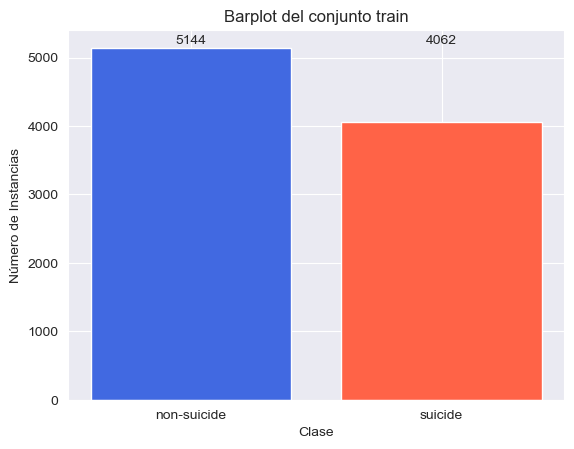

In [72]:
#Si queremos hacernos una idea de cuantas instancias hay por clase, podemos graficarlo mediante este barplot, mediante la libería matplotlib:
import matplotlib.pyplot as plt
# Reemplazar valores de las clases 0 y 1 por etiquetas deseadas
y_train = train['label'].replace({0: 'non-suicide', 1: 'suicide'})

# Contar las instancias por clase
value_counts = y_train.value_counts()
sorted_counts = value_counts.sort_index(ascending=True)
sorted_labels = sorted_counts.index
max_count = sorted_counts.max()

# Colores para las clases
colors = ['royalblue', 'tomato']

# Crear el gráfico de barras con colores
plt.bar(sorted_labels, sorted_counts, color=colors)
label_height = max_count + 10

for index, value in enumerate(sorted_counts):
    plt.text(index, label_height, str(value), ha='center', va='bottom')

plt.xticks(range(len(sorted_labels)), sorted_labels)
plt.xlabel('Clase')
plt.ylabel('Número de Instancias')
plt.title('Barplot del conjunto train')

In [73]:
print("Las instancias están repartidas en las dos clases de la siguiente forma:")
print(train['label'].value_counts(), end="\n")

Las instancias están repartidas en las dos clases de la siguiente forma:
label
0    5144
1    4062
Name: count, dtype: int64


Para ver cuantos valores faltantes tenemos

In [74]:
# Check for missing values in the DataFrame
missing_values = train.isnull().sum()

# Display the number of missing values for each column
print("Missing Values in the DataFrame:")
print(missing_values)

Missing Values in the DataFrame:
label    0
tweet    0
dtype: int64


Si queremos a ver si hay instancias repetidas:

In [75]:
# Check for duplicated instances
duplicated_instances = train.duplicated().sum()
print("Instancias duplicadas:", duplicated_instances)

Instancias duplicadas: 327


Rango de atributos:

In [76]:
# Range of values for each attribute
attribute_ranges = train.describe()
print("Rango de valores de los atributos:")
print(attribute_ranges)

Rango de valores de los atributos:
             label
count  9206.000000
mean      0.441234
std       0.496562
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max       1.000000


****Preproceso :**** Para que los tweets tengan la información más relevante vamos a aplicar un preproceso de tal forma que se quiten signos de puntuación, mayúsuculas, stopwords y vamos a lematizar las palabras para que nos den toda la misma información.

In [77]:
import re
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)

    return input_txt

print('Dataset size:',train.shape)
print('columns are:',train.columns)

Dataset size: (9206, 2)
columns are: Index(['label', 'tweet'], dtype='object')


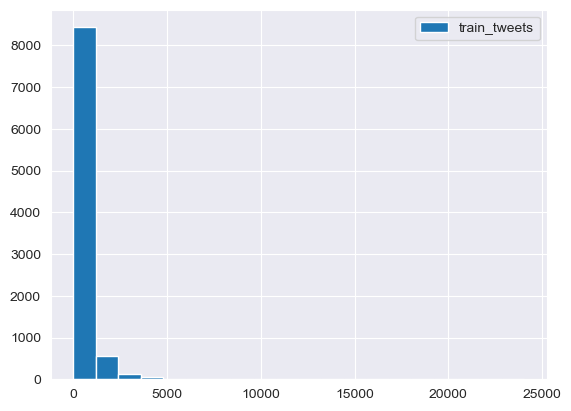

In [78]:
length_train = train['tweet'].str.len()

plt.hist(length_train, bins=20, label="train_tweets")
plt.legend()
plt.show()

* Se van a quitar los @ de usuario:

In [79]:
train['tidy_tweet'] = np.vectorize(remove_pattern)(train['tweet'], "@[\w]*")
print(type(train['tidy_tweet']))

<class 'pandas.core.series.Series'>


* Se van a remplazar mayúsuclas por minúsculas:

In [80]:
train['tidy_tweet'] = train['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")

* Se juntas las palabras separadas

In [81]:
train['tidy_tweet'] = train['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

* Tokenizacion

In [82]:
tokenized_tweet = train['tidy_tweet'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [life, meaningless, just, want, end, life, bad...
1    [muttering, wanna, die, myself, daily, for, fe...
2    [work, slave, really, feel, like, only, purpos...
3    [did, something, the, october, overdosed, just...
4    [feel, like, one, cares, just, want, die, mayb...
Name: tidy_tweet, dtype: object

* Se stematizan las palabras

In [83]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
tokenized_tweet.head()
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

train['tidy_tweet'] = tokenized_tweet

* Se borran las stopwords

In [84]:
import nltk.corpus

stopword = nltk.corpus.stopwords.words('english')
stopword.extend(['fuck', 'shit'])

In [85]:
def remove_stopwords(text):
  text = [word for word in text if word not in stopword]
  return text

# combi['tidy_tweet'] = combi['tidy_tweet'].apply(lambda x: remove_stopwords(x)) # stemming
# combi.head()

* Y con esto obtenemos ya los tweets preprocesados:

In [86]:
train['tidy_tweet'] = train['tidy_tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopword)]))

#visualize all the words our data using the wordcloud plot
all_words = ' '.join([text for text in train['tidy_tweet']])

** Palabras representtivas **

* Con esto podemos observar las palabras que más se repiten en general en los tweets:

C:\Users\david\anaconda3\envs\mineriaDD\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\david\anaconda3\envs\mineriaDD\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\david\anaconda3\envs\mineriaDD\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


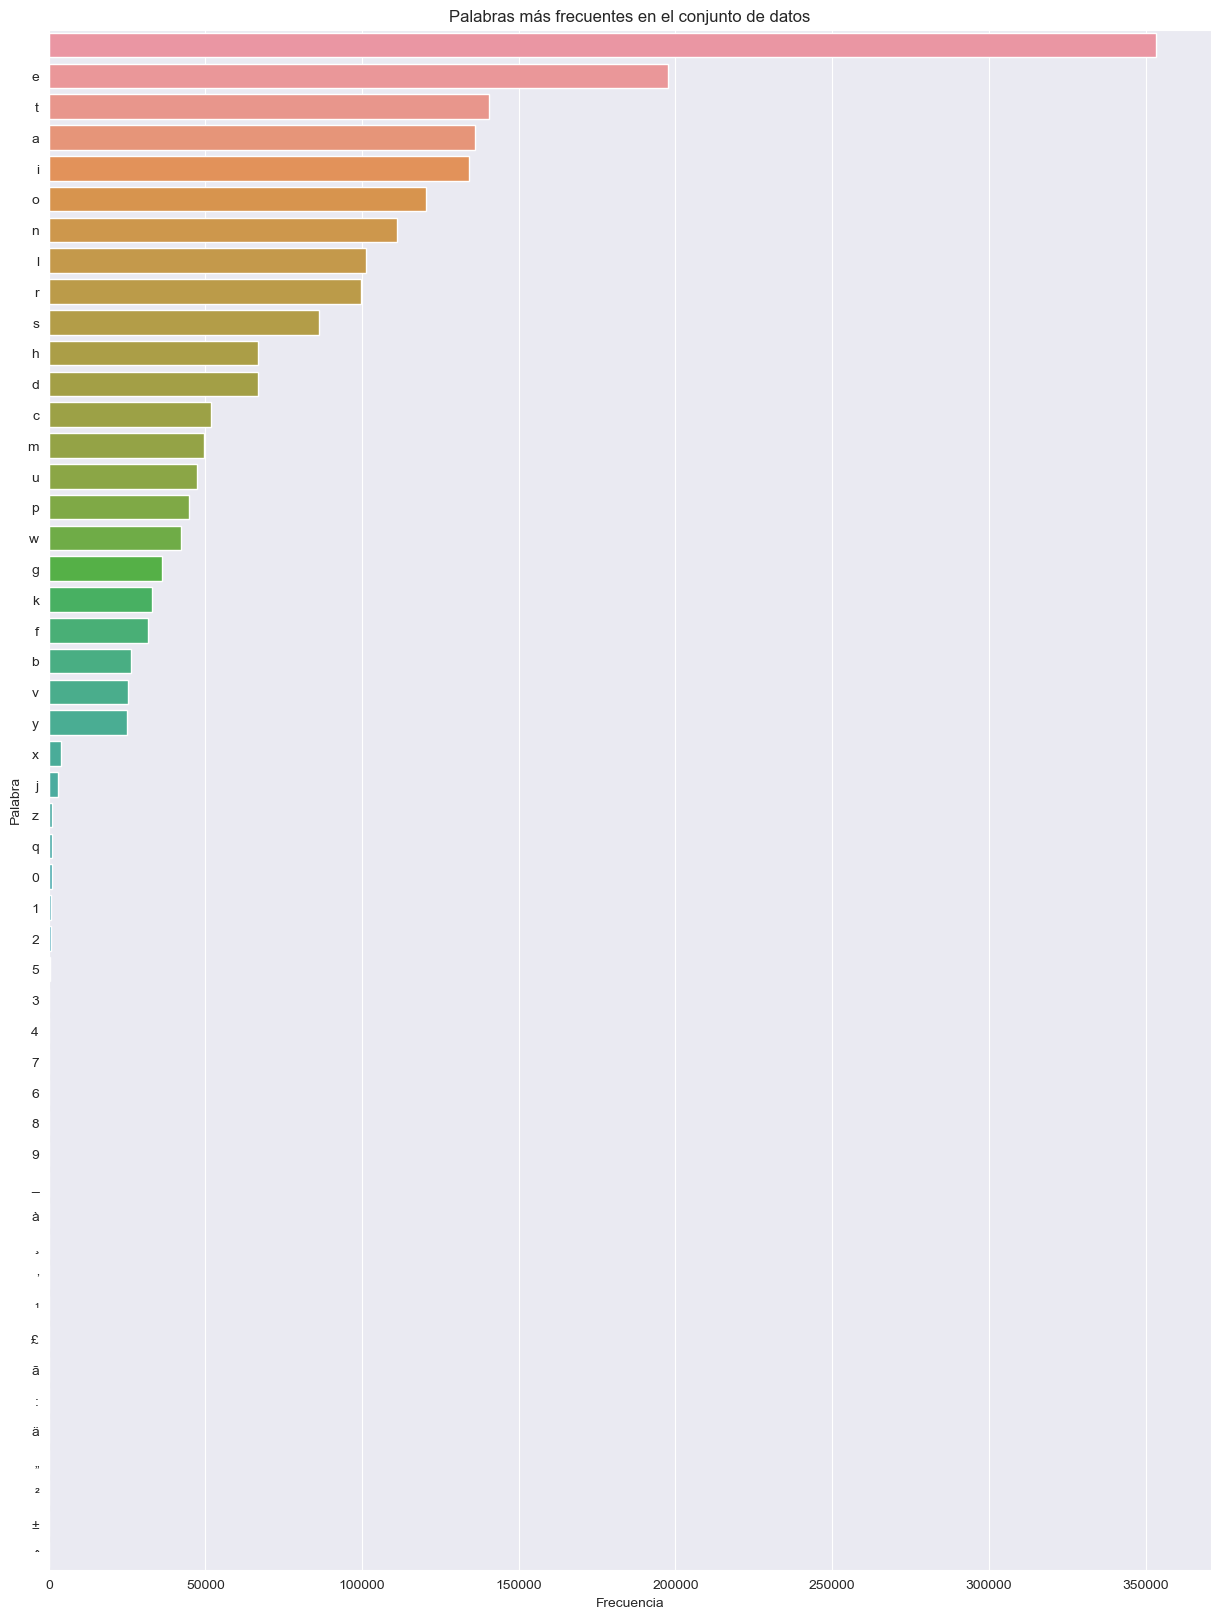

In [87]:
import seaborn as sns
from collections import Counter

# Obtener una lista de todas las palabras en el conjunto de datos
all_words1 = [word for tokens in tokenized_tweet for word in tokens]

# Contar la frecuencia de cada palabra
word_counts = Counter(all_words)

# Crear un DataFrame con las frecuencias de palabras
word_freq = pd.DataFrame(word_counts.items(), columns=['word', 'count']).sort_values(by='count', ascending=False)

# Crear un gráfico de barras para las 50 palabras más frecuentes
plt.figure(figsize=(15, 20))
sns.barplot(x='count', y='word', data=word_freq.iloc[:50])
plt.xlabel('Frecuencia')
plt.ylabel('Palabra')
plt.title('Palabras más frecuentes en el conjunto de datos')
plt.show()

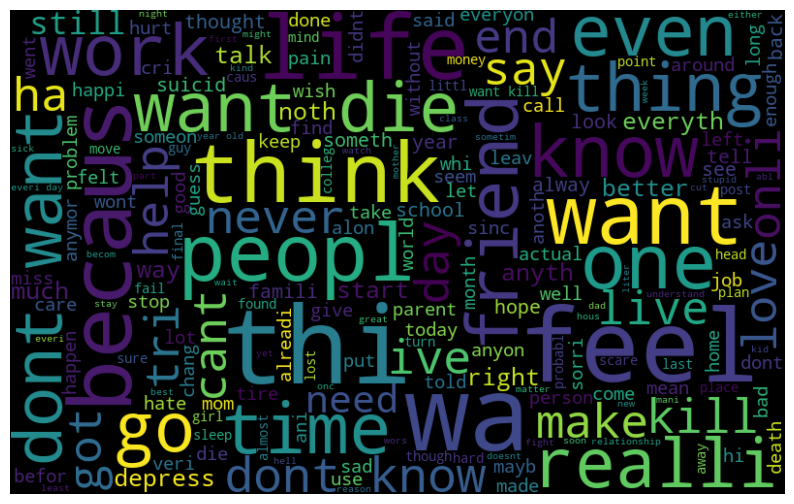

In [88]:
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

* Con esto podemos observar las palabras que más se repiten en los tweets con label si:

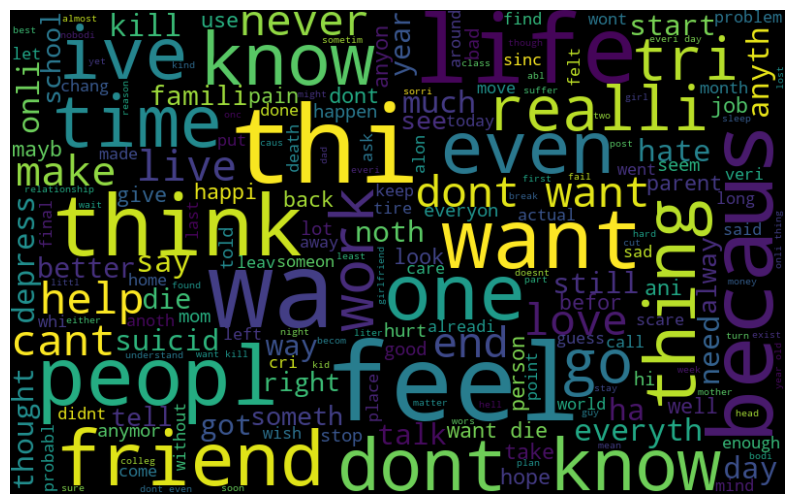

In [89]:
#Suicide
negative_words = ' '.join([text for text in train['tidy_tweet'][train['label'] == 1]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

* Con esto podemos observar las palabras que más se repiten en los tweets con label no:

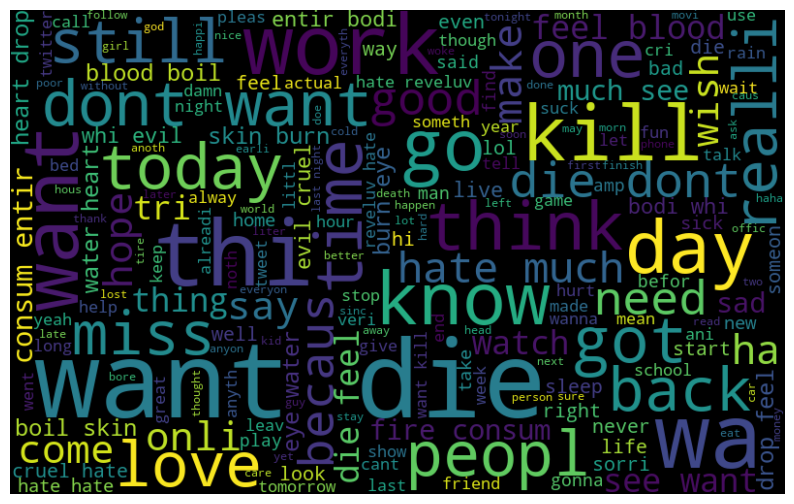

In [90]:
#Non-suicide
normal_words =' '.join([text for text in train['tidy_tweet'][train['label'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

**Vectorizacin**

* BOW (Bag of Words)

In [91]:
#Bag-of-words
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=20000, stop_words='english')
# bag-of-words feature matrix
bow = bow_vectorizer.fit_transform(train['tidy_tweet'])
bow.shape
# bow[:5]

(9206, 7400)

* TF-IDF (Term Frecuency, Inverse Document Frecuency)

In [92]:
#Tf-IDF
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import gensim

tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=20000, stop_words='english')
# TF-IDF feature matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(train['tidy_tweet'])
tfidf_matrix.shape

(9206, 7400)

* Word-Embbedings

In [93]:
#Word embbeding
tokenized_tweet = train['tidy_tweet'].apply(lambda x: x.split()) # tokenizing

model_w2v = gensim.models.Word2Vec(
            tokenized_tweet,
            vector_size=200, # desired no. of features/independent variables
            window=5, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 2, # no.of cores
            seed = 34)

model_w2v.train(tokenized_tweet, total_examples= len(train['tidy_tweet']), epochs=20)

(5813897, 7066000)

Ahora que tenemos entrenado el modelo de word-embbeding podemos ver por ejemplo para una palabra cúales son las que se parecen entre sí.

In [94]:
print(model_w2v.wv.most_similar(positive="die"))

[('want', 0.6490617990493774), ('ene', 0.5876951813697815), ('orbit', 0.5820766091346741), ('notexist', 0.5792716145515442), ('nevi', 0.575031578540802), ('stan', 0.572026252746582), ('yuta', 0.5660903453826904), ('schlanni', 0.5639622807502747), ('weeb', 0.5530544519424438), ('reveluv', 0.5372756123542786)]


In [95]:
print(model_w2v.wv.most_similar(positive="suicid"))

[('darkest', 0.5451333522796631), ('retain', 0.5425651669502258), ('myselfmi', 0.5283015370368958), ('outset', 0.5267248749732971), ('involuntarili', 0.5245559215545654), ('amdesper', 0.5236961245536804), ('desensit', 0.5214948058128357), ('chesti', 0.5190786719322205), ('execut', 0.5190000534057617), ('yesterdaymi', 0.51825350522995)]


In [96]:
model_w2v.wv.get_vector('suicid')

array([-1.88582148e-02, -1.69114619e-01,  2.30039462e-01, -9.73324180e-02,
        1.38825610e-01, -1.54742539e-01,  1.05144486e-01, -2.64505118e-01,
        5.24546243e-02,  2.54349560e-02, -1.43243328e-01, -2.73214966e-01,
       -3.63800704e-01, -1.06134377e-01,  1.75698921e-01,  7.40223303e-02,
        1.85956910e-01, -2.82174736e-01, -1.97932810e-01, -4.00600582e-01,
       -4.93959785e-01,  1.13262698e-01, -1.21319622e-01,  1.96561724e-01,
       -2.33532161e-01,  3.02344233e-01, -5.09844907e-02, -1.98121324e-01,
        4.05150384e-01, -3.83359529e-02, -3.46620567e-02, -2.12530419e-01,
       -1.99818417e-01,  3.66528153e-01,  2.69146293e-01, -2.26798996e-01,
       -1.36920542e-01,  1.54029638e-01,  4.08731580e-01, -1.42670125e-01,
       -3.61531973e-01, -8.71827379e-02,  6.30844533e-02, -5.30217767e-01,
       -1.39453024e-01, -4.97038243e-04,  2.47940585e-01, -1.49413750e-01,
       -2.75542252e-02, -1.58440787e-02,  1.38165563e-01, -2.01281026e-01,
        1.82255179e-01, -

No obstante, si queremos utilizar el modelo entrenado para predecir las etiquetas lo tenemos qu evectorizar de la siguiente manera:

In [97]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model_w2v.wv.get_vector(word).reshape((1, size))
            count += 1.
        except KeyError:  # handling the case where the token is not in vocabulary

            continue
    if count != 0:
        vec /= count
    return vec

In [98]:
wordvec_arrays = np.zeros((len(tokenized_tweet), 200))

for i in range(len(tokenized_tweet)):
    wordvec_arrays[i, :] = word_vector(tokenized_tweet[i], 200)

wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

(9206, 200)

In [99]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models.doc2vec import TaggedDocument

def add_label(twt):
    output = []
    for i, s in zip(twt.index, twt):
        output.append(TaggedDocument(s, ["tweet_" + str(i)]))
    return output

labeled_tweets = add_label(tokenized_tweet) # label all the tweets

labeled_tweets[:6]

[TaggedDocument(words=['life', 'meaningless', 'want', 'end', 'life', 'badli', 'life', 'complet', 'empti', 'dont', 'want', 'creat', 'mean', 'creat', 'mean', 'pain', 'long', 'hold', 'back', 'urg', 'run', 'car', 'head', 'first', 'next', 'person', 'come', 'opposit', 'way', 'stop', 'feel', 'jealou', 'tragic', 'charact', 'like', 'gomer', 'pile', 'swift', 'end', 'abl', 'bring', 'live'], tags=['tweet_0']),
 TaggedDocument(words=['mutter', 'wanna', 'die', 'daili', 'month', 'feel', 'worthless', 'soulmat', 'cant', 'live', 'thi', 'horribl', 'world', 'without', 'lone', 'wish', 'could', 'turn', 'part', 'brain', 'feel'], tags=['tweet_1']),
 TaggedDocument(words=['work', 'slave', 'realli', 'feel', 'like', 'onli', 'purpos', 'life', 'make', 'higher', 'man', 'money', 'parent', 'forc', 'colleg', 'much', 'plate', 'owe', 'lot', 'money', 'know', 'thi', 'easi', 'way', 'realli', 'tire', 'issu', 'top', 'deal', 'tension', 'america', 'well', 'want', 'rest'], tags=['tweet_2']),
 TaggedDocument(words=['someth', 'oc

In [100]:
model_d2v = gensim.models.Doc2Vec(dm=1, # dm = 1 for ‘distributed memory’ model
                                  dm_mean=1, # dm = 1 for using mean of the context word vectors
                                  vector_size=200, # no. of desired features
                                  window=5, # width of the context window
                                  negative=7, # if > 0 then negative sampling will be used
                                  min_count=5, # Ignores all words with total frequency lower than 2.
                                  workers=3, # no. of cores
                                  alpha=0.1, # learning rate
                                  seed = 23)

model_d2v.build_vocab([i for i in tqdm(labeled_tweets)])

model_d2v.train(labeled_tweets, total_examples= len(train['tidy_tweet']), epochs=15)

docvec_arrays = np.zeros((len(tokenized_tweet), 200))

for i in range(len(train)):
    docvec_arrays[i, :] = model_d2v.dv[i].reshape((1, 200))

docvec_df = pd.DataFrame(docvec_arrays)
print(docvec_df)
docvec_df.shape

100%|██████████| 9206/9206 [00:00<00:00, 1080016.86it/s]


           0         1         2         3         4         5         6    \
0     0.760991 -0.332220  0.274093 -0.062239 -0.463921  0.081363 -0.445484   
1     0.410831  0.537310  0.571104  0.090327  0.193346  0.641188 -0.435801   
2    -0.196397  0.476540 -0.192893  0.021961  0.194973 -0.420384  0.060745   
3    -0.400291  0.031354  1.248812  0.220324  0.439385  0.729126 -0.056397   
4    -0.020483  0.514898  0.100137  0.121167  0.034506  0.146284  0.044568   
...        ...       ...       ...       ...       ...       ...       ...   
9201 -0.022537  0.091227  0.068354 -0.164935 -0.003181  0.014558  0.048982   
9202 -0.009984  0.252009  0.137960 -0.291779 -0.192667  0.260158  0.119332   
9203  0.173676  0.402328  0.254448  0.036117  0.040142 -0.044765  0.213652   
9204 -0.105053  0.196291  0.107202  0.111360 -0.171587  0.130376 -0.048555   
9205 -0.037745  0.139085  0.086761 -0.016173  0.028440  0.058885  0.033181   

           7         8         9    ...       190       191    

(9206, 200)

**Clustering**

Vamos a aplicar clustering con KMeans para los 3 diferntes vectores que tenemos. Además, vamos a comparar el valor que da con una librería a hacer un KMeans implementado por nosotros.

In [101]:
from sklearn.cluster import KMeans
from sklearn.metrics import f1_score, precision_score, recall_score, silhouette_score, confusion_matrix

* KMeans con scikit-learn:

BOW

In [102]:
train_bow = bow
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

kmeans.fit(train_bow)
cluster_labels = kmeans.labels_

f1 = f1_score(train['label'], cluster_labels)

print("Puntuación F-Score para KMeans en todo el conjunto de datos:", f1)

C:\Users\david\anaconda3\envs\mineriaDD\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Puntuación F-Score para KMeans en todo el conjunto de datos: 0.534076433121019


C:\Users\david\anaconda3\envs\mineriaDD\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Puntuación de la Silueta para KMeans en BOW Features: 0.6251158091847413


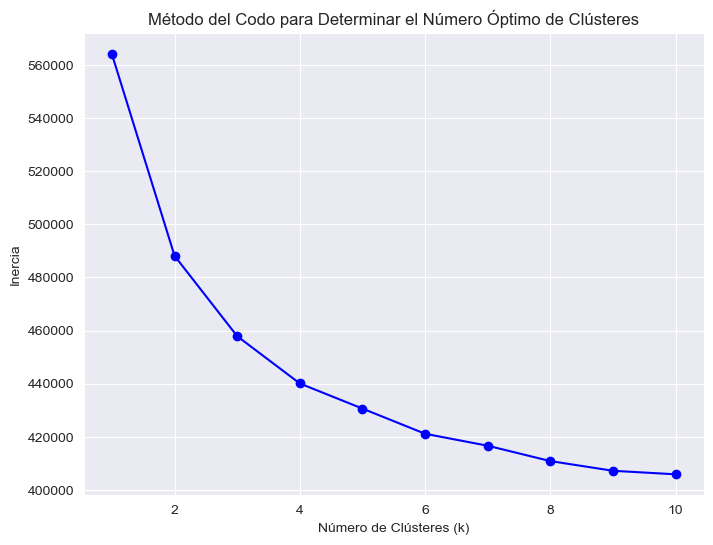

In [103]:
inertia = []

# Probamos diferentes valores de k (número de clústeres)
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(train_bow)
    inertia.append(kmeans.inertia_)  # Inertia mide la suma de las distancias al cuadrado de cada punto al centro de su clúster

# Dibujar el gráfico del Método del Codo
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o', linestyle='-', color='b')
plt.xlabel('Número de Clústeres (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo para Determinar el Número Óptimo de Clústeres')
plt.grid(True)

silhouette_avg = silhouette_score(train_bow, cluster_labels)
print("Puntuación de la Silueta para KMeans en BOW Features:", silhouette_avg)

TF-IDF

In [104]:
# TI-IDF Features
train_tfidf = tfidf_matrix

n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

kmeans.fit(train_tfidf)
cluster_labels = kmeans.labels_

f1 = f1_score(train['label'], cluster_labels)

print("Puntuación F-Score para KMeans en todo el conjunto de datos:", f1)


C:\Users\david\anaconda3\envs\mineriaDD\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Puntuación F-Score para KMeans en todo el conjunto de datos: 0.614554424915202


C:\Users\david\anaconda3\envs\mineriaDD\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Puntuación de la Silueta para KMeans en TF-IDF Features: 0.007926072988704928


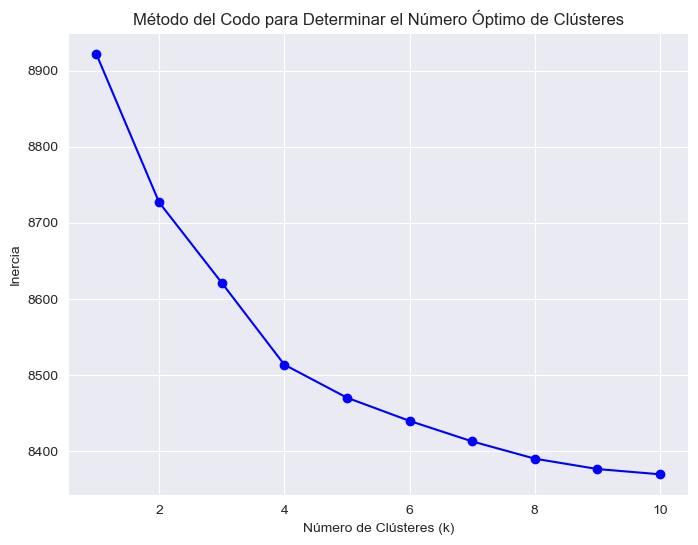

In [105]:
inertia = []

# Probamos diferentes valores de k (número de clústeres)
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(train_tfidf)
    inertia.append(kmeans.inertia_)  # Inertia mide la suma de las distancias al cuadrado de cada punto al centro de su clúster

# Dibujar el gráfico del Método del Codo
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o', linestyle='-', color='b')
plt.xlabel('Número de Clústeres (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo para Determinar el Número Óptimo de Clústeres')
plt.grid(True)

silhouette_avg = silhouette_score(train_tfidf, cluster_labels)
print("Puntuación de la Silueta para KMeans en TF-IDF Features:", silhouette_avg)

Word-Embbeding

* Para w2v

In [106]:
# Word2vec Features
train_w2v = wordvec_df

n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

kmeans.fit(train_w2v)
cluster_labels = kmeans.labels_

f1 = f1_score(train['label'], cluster_labels)

print("Puntuación F-Score para KMeans en todo el conjunto de datos:", f1)

C:\Users\david\anaconda3\envs\mineriaDD\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Puntuación F-Score para KMeans en todo el conjunto de datos: 0.7526451243923363


C:\Users\david\anaconda3\envs\mineriaDD\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\david\anaconda3\envs\mineriaDD\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\david\anaconda3\envs\mineriaDD\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\david\anaconda3\envs\mineriaDD\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_

Puntuación de la Silueta para KMeans en Word2Vec Features: 0.16489055132034486


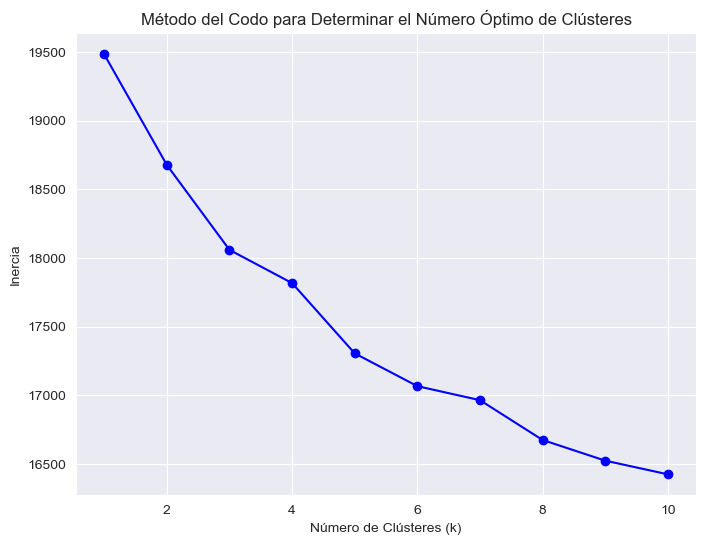

In [107]:
inertia = []

# Probamos diferentes valores de k (número de clústeres)
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(train_w2v)
    inertia.append(kmeans.inertia_)  # Inertia mide la suma de las distancias al cuadrado de cada punto al centro de su clúster

# Dibujar el gráfico del Método del Codo
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o', linestyle='-', color='b')
plt.xlabel('Número de Clústeres (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo para Determinar el Número Óptimo de Clústeres')
plt.grid(True)

silhouette_avg = silhouette_score(train_w2v, cluster_labels)
print("Puntuación de la Silueta para KMeans en Word2Vec Features:", silhouette_avg)

* Para d2v

In [108]:
# Doc2vec Features
train_d2v = docvec_df

n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

kmeans.fit(train_d2v)
cluster_labels = kmeans.labels_


f1 = f1_score(train['label'], cluster_labels)

print("Puntuación F-Score para KMeans en todo el conjunto de datos:", f1)


C:\Users\david\anaconda3\envs\mineriaDD\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Puntuación F-Score para KMeans en todo el conjunto de datos: 0.7521418020679468


C:\Users\david\anaconda3\envs\mineriaDD\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\david\anaconda3\envs\mineriaDD\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\david\anaconda3\envs\mineriaDD\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\david\anaconda3\envs\mineriaDD\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_

Puntuación de la Silueta para KMeans en Word2Vec Features: 0.25636264864739217


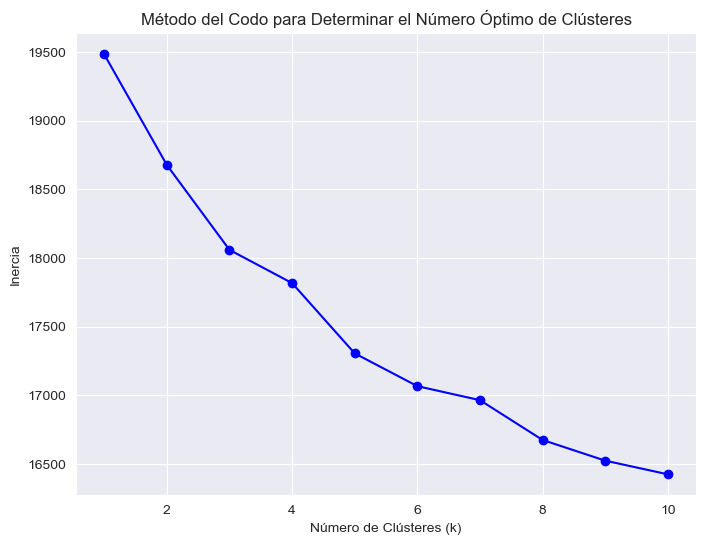

In [109]:
inertia = []

# Probamos diferentes valores de k (número de clústeres)
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(train_w2v)
    inertia.append(kmeans.inertia_)  # Inertia mide la suma de las distancias al cuadrado de cada punto al centro de su clúster

# Dibujar el gráfico del Método del Codo
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o', linestyle='-', color='b')
plt.xlabel('Número de Clústeres (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo para Determinar el Número Óptimo de Clústeres')
plt.grid(True)

silhouette_avg = silhouette_score(train_d2v, cluster_labels)
print("Puntuación de la Silueta para KMeans en Word2Vec Features:", silhouette_avg)

* KMeans implementado por nosotros:

In [110]:
from kMeans import *
from KMeans_cuda import *

BOW

In [ ]:
# Convierte la matriz a un formato adecuado para tu KMeans
bow_array = bow.toarray()
print(bow_array.shape)

# Luego, instanciamos la clase KMeans_Clustering y ajustamos el modelo a tus datos.
# Debes ajustar el número de clusters, el método de inicialización y otros parámetros según tu preferencia.
algoritmo = KMeans_Clustering(n_cluster=2, initialisation_method='2k', iter_max=100, p_value=2)
algoritmo.ajustar(instances=bow_array)

# Ahora que el modelo K-Means ha sido ajustado, puedes obtener las etiquetas predichas para tus datos.
# Las etiquetas estarán en algoritmo.labels
predicted_labels_KM_bow = algoritmo.labels

# Imprime las etiquetas predichas
print("Etiquetas predichas:", predicted_labels_KM_bow)

In [ ]:
algoritmo.dibujar_dendrograma()

TF-IDF

In [ ]:
# Convierte la matriz TF-IDF a un formato adecuado para tu KMeans
tfidf_array = tfidf_matrix.toarray()

# Luego, instanciamos la clase KMeans_Clustering y ajustamos el modelo a tus datos.
# Debes ajustar el número de clusters, el método de inicialización y otros parámetros según tu preferencia.
algoritmo = KMeans_Clustering(n_cluster=2, iter_max=10, p_value=2)
algoritmo.ajustar(instances=tfidf_array)

# Ahora que el modelo K-Means ha sido ajustado, puedes obtener las etiquetas predichas para tus datos.
# Las etiquetas estarán en algoritmo.labels
predicted_labels_KM_tfidf = algoritmo.labels

# Imprime las etiquetas predichas
print("Etiquetas predichas:", predicted_labels_KM_tfidf)

Word-Embbedding

* Para w2v

In [111]:
# Convierte la matriz a un formato adecuado para tu KMeans
w2v_array = train_w2v

# Luego, instanciamos la clase KMeans_Clustering y ajustamos el modelo a tus datos.
# Debes ajustar el número de clusters, el método de inicialización y otros parámetros según tu preferencia.
algoritmo = KMeans_Clustering(n_cluster=2, iter_max=20, p_value=2)
algoritmo.ajustar(w2v_array)

# Ahora que el modelo K-Means ha sido ajustado, puedes obtener las etiquetas predichas para tus datos.
# Las etiquetas estarán en algoritmo.labels
predicted_labels_KM_w2v = algoritmo.labels

# Imprime las etiquetas predichas
print("Etiquetas predichas:", predicted_labels_KM_w2v)

Algoritmo inicializado con clusters aleatorios
Calculando mediante CPU

Iteracion 0
Número de instancias para cluster  0 	 266
Número de instancias para cluster  1 	 8940

Iteracion 1
Número de instancias para cluster  0 	 841
Número de instancias para cluster  1 	 8365

Iteracion 2
Número de instancias para cluster  0 	 1544
Número de instancias para cluster  1 	 7662

Iteracion 3
Número de instancias para cluster  0 	 2020
Número de instancias para cluster  1 	 7186

Iteracion 4
Número de instancias para cluster  0 	 2320
Número de instancias para cluster  1 	 6886

Iteracion 5
Número de instancias para cluster  0 	 2495
Número de instancias para cluster  1 	 6711

Iteracion 6
Número de instancias para cluster  0 	 2593
Número de instancias para cluster  1 	 6613

Iteracion 7
Número de instancias para cluster  0 	 2664
Número de instancias para cluster  1 	 6542

Iteracion 8
Número de instancias para cluster  0 	 2709
Número de instancias para cluster  1 	 6497

Iteracion 9
Número de

In [112]:
algoritmo.guardar_modelo()

Modelo guardado con:  2 y con los centroides:  [[-0.0320909  -0.0575606   0.10794999 -0.02519867 -0.24473259  0.10008279
  -0.00614693 -0.12725848  0.24587077  0.0475628  -0.14749347 -0.11573978
  -0.17426412 -0.07771589 -0.18892103  0.14805469  0.35276476  0.10280498
  -0.14029893 -0.14597318 -0.06596197  0.02396113 -0.19721177  0.06890979
  -0.10801582  0.1760228  -0.13810351 -0.14656585  0.11329652 -0.03103019
   0.00471153 -0.20802464 -0.04740707  0.20096247 -0.08424129 -0.23807882
  -0.04533149  0.1060935   0.07067376 -0.06894765 -0.16606852 -0.1462178
   0.06373765  0.12496658  0.02826696  0.01603951 -0.06657776 -0.00555651
  -0.19789663 -0.18150397  0.19414808  0.0569368   0.13735822  0.07153088
   0.03366997 -0.03219942 -0.20554332 -0.0519785   0.09222964 -0.0836542
  -0.03943675 -0.00437296  0.1544729   0.00775995  0.01176025  0.04325922
   0.14125396 -0.06001971 -0.11475496  0.07018612  0.23830186  0.00589028
   0.03063754 -0.03460174  0.04103046 -0.2119915  -0.14840537 -0.04

In [ ]:
algoritmo.dibujar_dendrograma()

In [113]:
# Convierte la matriz a un formato adecuado para tu KMeans
d2v_array = train_d2v

# Luego, instanciamos la clase KMeans_Clustering y ajustamos el modelo a tus datos.
# Debes ajustar el número de clusters, el método de inicialización y otros parámetros según tu preferencia.
algoritmo = KMeans_Clustering(n_cluster=2, iter_max=20, p_value=2)
algoritmo.ajustar(d2v_array)

# Ahora que el modelo K-Means ha sido ajustado, puedes obtener las etiquetas predichas para tus datos.
# Las etiquetas estarán en algoritmo.labels
predicted_labels_KM_d2v = algoritmo.labels

# Imprime las etiquetas predichas
print("Etiquetas predichas:", predicted_labels_KM_d2v)

Algoritmo inicializado con clusters aleatorios
Calculando mediante CPU

Iteracion 0
Número de instancias para cluster  0 	 7638
Número de instancias para cluster  1 	 1568

Iteracion 1
Número de instancias para cluster  0 	 7393
Número de instancias para cluster  1 	 1813

Iteracion 2
Número de instancias para cluster  0 	 7184
Número de instancias para cluster  1 	 2022

Iteracion 3
Número de instancias para cluster  0 	 7051
Número de instancias para cluster  1 	 2155

Iteracion 4
Número de instancias para cluster  0 	 6951
Número de instancias para cluster  1 	 2255

Iteracion 5
Número de instancias para cluster  0 	 6872
Número de instancias para cluster  1 	 2334

Iteracion 6
Número de instancias para cluster  0 	 6805
Número de instancias para cluster  1 	 2401

Iteracion 7
Número de instancias para cluster  0 	 6754
Número de instancias para cluster  1 	 2452

Iteracion 8
Número de instancias para cluster  0 	 6712
Número de instancias para cluster  1 	 2494

Iteracion 9
Número 

In [ ]:
algoritmo.dibujar_dendrograma()

In [114]:
algoritmo.guardar_modelo()

Modelo guardado con:  2 y con los centroides:  [[ 8.40610117e-02  1.67354882e-01  1.56976581e-01  3.93866040e-02
   6.41271565e-03  1.01224110e-02  6.90485090e-02 -2.12325588e-01
   6.16588257e-02 -1.74973100e-01  1.44831061e-01 -5.32346554e-02
   1.46090686e-01 -1.24233387e-01  4.43139300e-02 -1.05087440e-02
  -2.46389359e-02  1.23712532e-01 -2.96578351e-02 -1.61205068e-01
   7.83055946e-02  2.74642613e-02 -6.81379363e-02  8.40793103e-02
  -1.19456075e-01  1.16639525e-01 -1.05034016e-01 -1.54740378e-01
  -1.59087420e-01 -1.44818604e-01 -5.95076606e-02  3.38850357e-02
   1.86130889e-02  3.70932114e-03 -1.71500042e-01  1.39803737e-01
   5.63306324e-02 -1.13979816e-01  9.00093615e-02 -6.21751882e-02
  -2.14481011e-01 -1.53946131e-01 -8.13728496e-02 -2.74962056e-02
  -2.47400522e-01 -2.30018094e-01  1.59502588e-02  1.49811223e-01
   1.86071500e-01 -1.47322670e-03  3.07318289e-02 -1.42635688e-01
  -1.99429706e-01  4.17495728e-01  8.14244971e-02 -5.05296513e-02
  -2.60044541e-02  8.44295323

* Representación:

Para hacenos una idea de como se distribuyen los puntos en el espacio, podemos usar PCA.

In [115]:
from sklearn.decomposition import PCA

print('Dim originally: ',train_w2v.shape)
# Reducir las dimensiones para visualizarlas: PCA
pca = PCA(n_components=4)
pca.fit(train_w2v)
# Cambio de base a dos dimensiones PCA
X_train_PCAspace = pca.transform(train_w2v)
print('Dim after PCA: ',X_train_PCAspace.shape)

Dim originally:  (9206, 200)
Dim after PCA:  (9206, 4)


Text(0.5, 1.0, 'Clustering en el espacio de PCA')

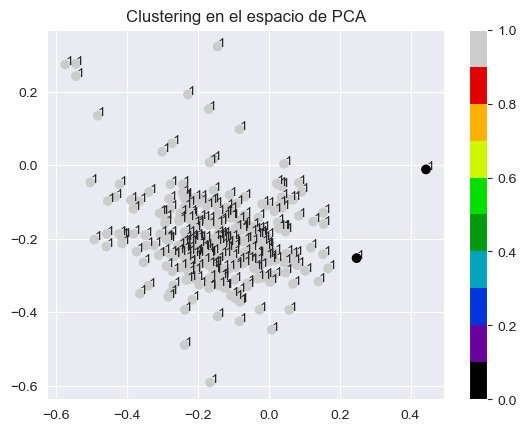

In [116]:
samples = 300
# Dibujar los puntos en el espacio, color: cluster, etiqueta-numérica: clase
# Color del punto: cluster
sc = plt.scatter(X_train_PCAspace[:samples, 0], X_train_PCAspace[:samples, 1],
                 cmap=plt.get_cmap('nipy_spectral', 10), c=predicted_labels_KM_w2v[:samples])
plt.colorbar()
# Etiqueta numérica: clase
for i in range(samples):
    plt.text(X_train_PCAspace[i, 0], X_train_PCAspace[i, 1], train['label'].iloc[i])  # Utiliza .iloc[i] para obtener la etiqueta de la fila i
plt.title('Clustering en el espacio de PCA')


In [117]:
#TSNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
X_train_TSNE = tsne.fit_transform(train_w2v)

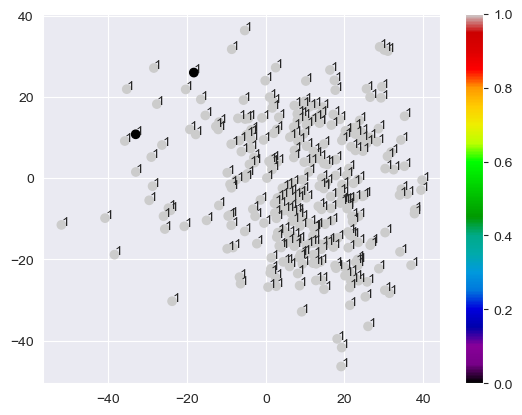

In [118]:
# Dibujar sólo unas pocas instancias (las primeras 300)
samples = 300
plt.scatter(X_train_TSNE[:samples, 0], X_train_TSNE[:samples, 1], c=predicted_labels_KM_w2v[:samples], cmap='nipy_spectral')
plt.colorbar()
# Etiqueta numérica: clase
for i in range(samples):
    plt.text(X_train_TSNE[i, 0], X_train_TSNE[i, 1], train['label'].iloc[i])  # Utiliza .iloc[i] para obtener la etiqu


* Para saber la tasa de error podemos usar la matriz de confusión y con ello calcular la tasa de error:

Text(0.5, 1.0, 'Matriz de Confusión sin relabelización para w2v')

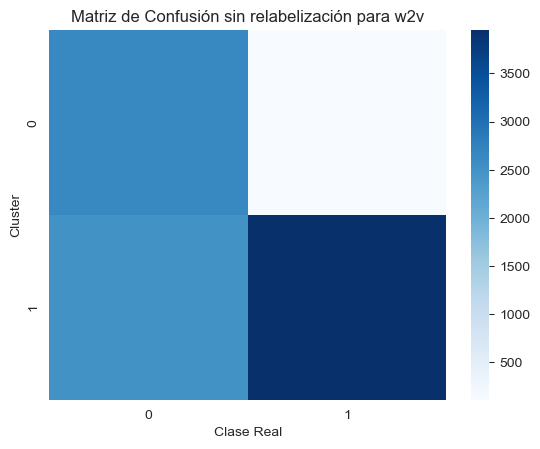

In [119]:
# Visualizar la matriz de confusión con el número de instancias
# El atributo generado por K-means es int, hay que pasarlos a string
to_string = lambda x : str(x)
# Obtener matriz de confusión Class to clustering eval
cm = confusion_matrix(np.vectorize(to_string)(predicted_labels_KM_w2v), np.vectorize(to_string)(train['label']))
# Mapa de calor a partir de la matriz de confusion sin números
ax = sns.heatmap(cm, annot=False, cmap="Blues")
plt.xlabel('Clase Real')
plt.ylabel('Cluster')
plt.title('Matriz de Confusión sin relabelización para w2v')

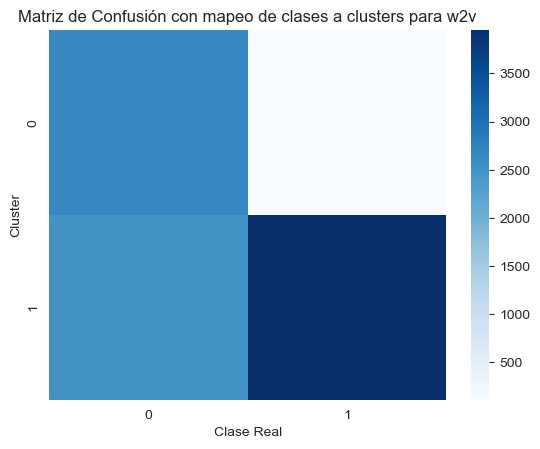

In [120]:
# Define una función para mapear clases reales a clusters
def class_to_cluster(predicted_labels, true_labels, cluster_labels):
    cluster_mapping = {}  # Diccionario para mapear clases a clusters
    for cluster_label in cluster_labels:
        cluster_instances = true_labels[predicted_labels == cluster_label]
        unique_classes, class_counts = np.unique(cluster_instances, return_counts=True)
        most_frequent_class = unique_classes[np.argmax(class_counts)]
        cluster_mapping[cluster_label] = most_frequent_class
    return cluster_mapping

# Supongamos que tienes predicted_labels_KM_w2v y train['label'] como tus etiquetas
# y los clusters generados por K-means en cluster_labels
cluster_mapping = class_to_cluster(predicted_labels_KM_w2v, train['label'], np.unique(predicted_labels_KM_w2v))

# Mapea las etiquetas reales a los clusters utilizando el diccionario cluster_mapping
mapped_labels = np.vectorize(cluster_mapping.get)(predicted_labels_KM_w2v)

# Calcula la matriz de confusión
cm = confusion_matrix(np.vectorize(to_string)(mapped_labels), np.vectorize(to_string)(train['label']))

# Crea el mapa de calor a partir de la matriz de confusión
ax = sns.heatmap(cm, annot=False, cmap="Blues")
plt.xlabel('Clase Real')
plt.ylabel('Cluster')
plt.title('Matriz de Confusión con mapeo de clases a clusters para w2v')
plt.show()

In [121]:
# Calculate the confusion matrix with the reassigned labels
cm = confusion_matrix(train['label'], predicted_labels_KM_w2v)
total_correct = np.trace(cm)  # Suma de valores en la diagonal principal
total_samples = np.sum(cm)    # Suma de todos los valores en la matriz de confusión

# Calcular el número total de clasificaciones incorrectas
total_incorrect = total_samples - total_correct

# Calcular la tasa de error
error_rate = total_incorrect / total_samples

print("Tasa de Error:", error_rate)

silhouette_avg = silhouette_score(train_w2v, predicted_labels_KM_w2v)
print("Puntuación de la Silueta para KMeans en Word2Vec Features:", silhouette_avg)

Tasa de Error: 0.28340212904627415
Puntuación de la Silueta para KMeans en Word2Vec Features: 0.16493934649417136


Text(0.5, 1.0, 'Matriz de Confusión sin relabelización para d2v')

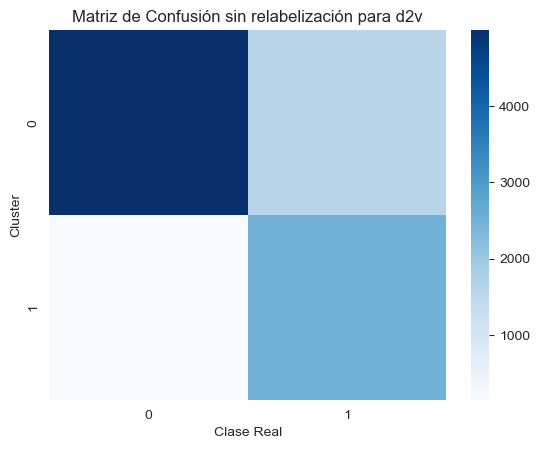

In [122]:
# Visualizar la matriz de confusión con el número de instancias
# El atributo generado por K-means es int, hay que pasarlos a string
to_string = lambda x : str(x)
# Obtener matriz de confusión Class to clustering eval
cm = confusion_matrix(np.vectorize(to_string)(predicted_labels_KM_d2v), np.vectorize(to_string)(train['label']))
# Mapa de calor a partir de la matriz de confusion sin números
ax = sns.heatmap(cm, annot=False, cmap="Blues")
plt.xlabel('Clase Real')
plt.ylabel('Cluster')
plt.title('Matriz de Confusión sin relabelización para d2v')

Con esta porción lo que hemos hecho es que cada cluster tenga como nombre el número que mas lo representa, de esta forma vamos a conseguir la matriz diagonal, en el caso de que el clusterint haya sido de buena calidad, y vamos a poder medir el error calculando cuantas instancias están fuera de la matriz diagonal.

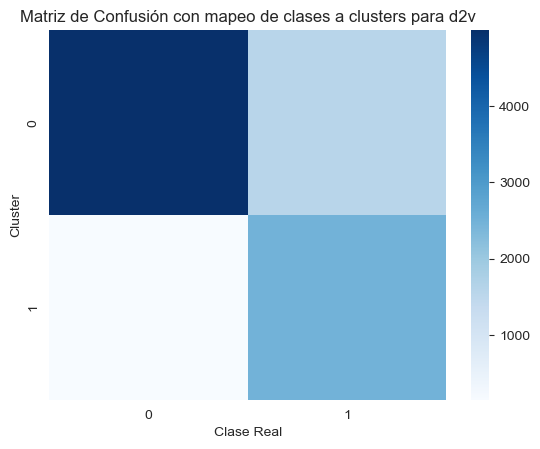

In [124]:
# Define una función para mapear clases reales a clusters
def class_to_cluster(predicted_labels, true_labels, cluster_labels):
    cluster_mapping = {}  # Diccionario para mapear clases a clusters
    for cluster_label in cluster_labels:
        cluster_instances = true_labels[predicted_labels == cluster_label]
        unique_classes, class_counts = np.unique(cluster_instances, return_counts=True)
        most_frequent_class = unique_classes[np.argmax(class_counts)]
        cluster_mapping[cluster_label] = most_frequent_class
    return cluster_mapping

# Supongamos que tienes predicted_labels_KM_w2v y train['label'] como tus etiquetas
# y los clusters generados por K-means en cluster_labels
cluster_mapping = class_to_cluster(predicted_labels_KM_d2v, train['label'], np.unique(predicted_labels_KM_d2v))

# Mapea las etiquetas reales a los clusters utilizando el diccionario cluster_mapping
mapped_labels = np.vectorize(cluster_mapping.get)(predicted_labels_KM_d2v)

# Calcula la matriz de confusión
cm = confusion_matrix(np.vectorize(to_string)(mapped_labels), np.vectorize(to_string)(train['label']))

# Crea el mapa de calor a partir de la matriz de confusión
ax = sns.heatmap(cm, annot=False, cmap="Blues")
plt.xlabel('Clase Real')
plt.ylabel('Cluster')
plt.title('Matriz de Confusión con mapeo de clases a clusters para d2v')
plt.show()

In [125]:
cm = confusion_matrix(train['label'], predicted_labels_KM_d2v)
total_correct = np.trace(cm)
total_samples = np.sum(cm)

total_incorrect = total_samples - total_correct

error_rate = total_incorrect / total_samples

print("Tasa de Error:", error_rate)

silhouette_avg = silhouette_score(train_d2v, predicted_labels_KM_d2v)
print("Puntuación de la Silueta para KMeans en Word2Vec Features:", silhouette_avg)

Tasa de Error: 0.18835542037801434
Puntuación de la Silueta para KMeans en Word2Vec Features: 0.25932675629931173


**Evaluación del modelo**

Para hacernos una idea de la bonanza del modelo, debemos usar métricas como F-Score, Precision, Recall. Además, métricas como la silueta o Kaminski nos pueden dar una idea de la solapación existente.

In [61]:
# Calculate the F-Score
f_score = f1_score(train['label'], predicted_labels_KM_bow)

# Calculate the precision
precision = precision_score(train['label'], predicted_labels_KM_bow)

# Calculate the recall
recall = recall_score(train['label'], predicted_labels_KM_bow)

# Print the evaluation metrics
print("F-Score para nuestro KMeans con BOW:", f_score)
print("Precision nuestro KMeans con BOW:", precision)
print("Recall nuestro KMeans con BOW:", recall)

NameError: name 'predicted_labels_KM_bow' is not defined

In [ ]:
# Calculate the F-Score
f_score = f1_score(train['label'], predicted_labels_KM_tfidf)

# Calculate the precision
precision = precision_score(train['label'], predicted_labels_KM_tfidf)

# Calculate the recall
recall = recall_score(train['label'], predicted_labels_KM_tfidf)

# Print the evaluation metrics
print("F-Score para nuestro KMeans con tf-idf:", f_score)
print("Precision nuestro KMeans con tf-idf:", precision)
print("Recall nuestro KMeans con tf-idf:", recall)

In [126]:
# Calculate the F-Score
f_score = f1_score(train['label'], predicted_labels_KM_w2v)

# Calculate the precision
precision = precision_score(train['label'], predicted_labels_KM_w2v)

# Calculate the recall
recall = recall_score(train['label'], predicted_labels_KM_w2v)

# Print the evaluation metrics
print("F-Score para nuestro KMeans con Word-Embbeding (w2v):", f_score)
print("Precision nuestro KMeans con Word-Embbeding(w2v):", precision)
print("Recall nuestro KMeans con Word-Embbeding(w2v):", recall)

F-Score para nuestro KMeans con Word-Embbeding (w2v): 0.7516893499571714
Precision nuestro KMeans con Word-Embbeding(w2v): 0.612723041117145
Recall nuestro KMeans con Word-Embbeding(w2v): 0.9721811915312654


In [127]:
# Calculate the F-Score
f_score = f1_score(train['label'], predicted_labels_KM_d2v)

# Calculate the precision
precision = precision_score(train['label'], predicted_labels_KM_d2v)

# Calculate the recall
recall = recall_score(train['label'], predicted_labels_KM_d2v)

# Print the evaluation metrics
print("F-Score para nuestro KMeans con Word-Embbeding(d2v):", f_score)
print("Precision nuestro KMeans con Word-Embbeding(d2v):", precision)
print("Recall nuestro KMeans con Word-Embbeding(d2v):", recall)

F-Score para nuestro KMeans con Word-Embbeding(d2v): 0.7411167512690355
Precision nuestro KMeans con Word-Embbeding(d2v): 0.9415781487101669
Recall nuestro KMeans con Word-Embbeding(d2v): 0.6110290497291975


**Clasificación de nuevas instancias.**

In [128]:
from clasificarNuevaInstancia import preproceso


nuevos_mensajes = ["Este es un mensaje de prueba", "Otro mensaje para probar", "Más mensajes"]
opcion = 'w2v'

print("Se van a preprocesar y vectorizar las nuevas instancias con: ", opcion)

nuevoArray = preproceso(nuevos_mensajes,opcion)

print("vectorizado completado con ", opcion)
print(nuevoArray)

modelo = KMeans_Clustering()

nuevoArray = modelo.cargar_modelo_y_asignar_clusters(nuevoArray)
print("fin")
print(nuevoArray)

Se van a preprocesar y vectorizar las nuevas instancias con:  w2v
vectorizado completado con  w2v
        0        1         2         3         4         5         6    \
0 -0.004371 -0.00496 -0.003818  0.003722 -0.003861 -0.002573 -0.004927   
1 -0.004371 -0.00496 -0.003818  0.003722 -0.003861 -0.002573 -0.004927   
2 -0.004371 -0.00496 -0.003818  0.003722 -0.003861 -0.002573 -0.004927   

        7         8         9    ...       190       191       192       193  \
0  0.001511 -0.004013 -0.000159  ... -0.000673  0.001897 -0.003375 -0.000308   
1  0.001511 -0.004013 -0.000159  ... -0.000673  0.001897 -0.003375 -0.000308   
2  0.001511 -0.004013 -0.000159  ... -0.000673  0.001897 -0.003375 -0.000308   

            194       195      196       197      198      199  
0 -3.606081e-07  0.002043  0.00085  0.000258  0.00143 -0.00485  
1 -3.606081e-07  0.002043  0.00085  0.000258  0.00143 -0.00485  
2 -3.606081e-07  0.002043  0.00085  0.000258  0.00143 -0.00485  

[3 rows x 200 columns]


TypeError: object of type 'int' has no len()